# Practical 3 - Graph Classification and Link Prediction using GNNs
---

**Tutorial overview:** In this tutorial, you will learn how Graph Networks can be used to perform graph classification on the MUTAG molecule property dataset and link prediction on the CORA citation network.


**Tutorial outline**:
- Graph classification task with MUTAG dataset
- Edge prediction task with CORA dataset

## Theory Overview

### Practical 1 and 2 Recap

The previous practicals introduced the main components of Graph Neural Networks. Based on the understanding behind these components, we designed two GNN models from scratch: Graph Convolutional Network (GCN) and a modification that utilizes Graph Attention (GAT). In this tutorial, we see how these components make up the general Graph Network (GN) model in jraph. Furthermore, we will demonstrate how to solve different graph-related tasks using GNs on two more real-world datasets.

### Graph Prediction Tasks
What are the kinds of problems we want to solve on graphs?


The tasks fall into roughly three categories:

1. **Node Classification**: E.g. what is the topic of a paper given a citation network of papers? We already saw how to tackle this task in the previous practicals using the Karate Club and OGBN-Arxiv datasets.
2. **Graph Classification**: E.g. is this protein molecule (represented as a graph) likely going to be effective? In the first half of this colab, we will build and train a GNN that precisely solves the task of predicting the property of different molecules.
3. **Link Prediction / Edge Classification**: E.g. are two people in a social network friends? In the second half of this colab, we introduce the link prediction task and its training objectives in detail. We will build and train a GNN to predict if a paper is likely / not-likely to cite another paper.
<center><image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/graph_tasks.png" width="700px"></center>.

*The three main graph learning tasks. Image source: Petar Veličković.*



### Graph Network Model definition
Graph networks (GN) framework defines a class of functions for
relational reasoning over graph-structured representations.

A GN block contains three “update” functions $\phi$,
mapped across all nodes, edges and graph properties to compute per-node/edge/graph updata; and three “aggregation” functions $\rho$. We will define these  functions in the following exercises.

source: https://arxiv.org/pdf/1806.01261.pdf

### Setup

In [1]:
!pip install git+https://github.com/deepmind/jraph.git
!pip install flax
!pip install dm-haiku

  Cloning https://github.com/deepmind/jraph.git to /tmp/pip-req-build-6c5an_og
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/jraph.git /tmp/pip-req-build-6c5an_og
  Resolved https://github.com/deepmind/jraph.git to commit 51f5990104f7374492f8f3ea1cbc47feb411c69c
  Preparing metadata (setup.py) ... done
  Created wheel for jraph: filename=jraph-0.0.6.dev0-py3-none-any.whl size=91255 sha256=723b0a2c964f36bc3d83e1f70d5276c78ebdf10667b427bfb8e656f44cc7c886
  Stored in directory: /tmp/pip-ephem-wheel-cache-qt8fbb9e/wheels/76/61/34/8fb9aa4dac00d471de4a5f7157614181de683c445fc2d640db
Successfully built jraph
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.3/360.3 kB 5.4 MB/s eta 0:00:00


In [2]:
# Imports
%matplotlib inline
import functools
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.tree_util as tree
import jraph
import flax
import haiku as hk
import optax
import pickle
import numpy as onp
import networkx as nx
from typing import Any, Callable, Dict, List, Optional, Tuple

In [3]:
# Utils for visualization
def convert_jraph_to_networkx_graph(jraph_graph: jraph.GraphsTuple) -> nx.Graph:
  nodes, edges, receivers, senders, _, _, _ = jraph_graph
  nx_graph = nx.DiGraph()
  if nodes is None:
    for n in range(jraph_graph.n_node[0]):
      nx_graph.add_node(n)
  else:
    for n in range(jraph_graph.n_node[0]):
      nx_graph.add_node(n, node_feature=nodes[n])
  if edges is None:
    for e in range(jraph_graph.n_edge[0]):
      nx_graph.add_edge(int(senders[e]), int(receivers[e]))
  else:
    for e in range(jraph_graph.n_edge[0]):
      nx_graph.add_edge(
          int(senders[e]), int(receivers[e]), edge_feature=edges[e])
  return nx_graph

In [4]:
def draw_jraph_graph_structure(jraph_graph: jraph.GraphsTuple) -> None:
  nx_graph = convert_jraph_to_networkx_graph(jraph_graph)
  pos = nx.spring_layout(nx_graph)
  nx.draw(
      nx_graph, pos=pos, with_labels=True, node_size=500, font_color='yellow')

## [Optional for fun I] Graph Network Model Definition
We will use jraph.GraphNetwork() to build our graph model. The GraphNetwork architecture is defined in Battaglia et al. (2018).

We first define update functions for nodes and edges. We will use MLP blocks for all three.



In [5]:
# Adapted from https://github.com/deepmind/jraph/blob/master/jraph/ogb_examples/train.py

EMBEDDING_SIZE = 128
@jraph.concatenated_args
def edge_update_fn(feats: jnp.ndarray) -> jnp.ndarray:
  """Edge update function for graph net."""
  # Define an MLP(128,128) with relu activation

  ################
  # YOUR CODE HERE
  # net = ...
  net = hk.Sequential(
      [hk.Linear(EMBEDDING_SIZE), jax.nn.relu,
       hk.Linear(EMBEDDING_SIZE)])
  ################

  return net(feats)

@jraph.concatenated_args
def node_update_fn(feats: jnp.ndarray) -> jnp.ndarray:
  """Node update function for graph net."""
  # Define an MLP(128,128) with relu activation

  ################
  # YOUR CODE HERE
  # net = ...
  net = hk.Sequential(
      [hk.Linear(EMBEDDING_SIZE), jax.nn.relu,
       hk.Linear(EMBEDDING_SIZE)])

  ################
  return net(feats)

Now we want to make our Graph Network suitable for the task of graph classification.

The main difference from node classification task is that instead of observing individual node latents, we are now attempting to summarize them into one embedding vector, representative of the entire graph, which we then use to predict the class of this graph.

Hence, we need to implement the update function for the full graph (global), using an MLP that eventually classifies i

In [6]:
@jraph.concatenated_args
def update_global_fn(feats: jnp.ndarray) -> jnp.ndarray:
  """Global update function for graph net."""
  # Define an MLP(128,2) as it must provide a prediction for the graph
  # assuming a standard binary classification task

  ################
  # YOUR CODE HERE
  # net = ...
  net = hk.Sequential(
      [hk.Linear(EMBEDDING_SIZE), jax.nn.relu,
       hk.Linear(2)])
  ################
  return net(feats)


We are ready to define the network builder

In [7]:
def net_fn_graph_classification(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  # Add a global parameter for graph classification.
  graph = graph._replace(globals=jnp.zeros([graph.n_node.shape[0], 1]))

  # 1. Define an embedder function that will linearly project
  # the input graph, i.e., the nodes, the edges, and the globals.
  # Project them all to 128-dimensional space.
  # Use jraph.GraphMapFeatures setting each layer accordingly
  # embedder = jraph.GraphMapFeatures( ... , ... , ... )

  # 2. Define the network using jraph.GraphNetwork and the
  # update functions defined previously for nodes, edges and global
  # net = jraph.GraphNetwork( ... , ... , ...)

  ################
  # YOUR CODE HERE
  # embedder = ...
  # net = ...
  embedder = jraph.GraphMapFeatures(
      hk.Linear(EMBEDDING_SIZE), hk.Linear(EMBEDDING_SIZE), hk.Linear(EMBEDDING_SIZE))
  net = jraph.GraphNetwork(
      update_node_fn=node_update_fn,
      update_edge_fn=edge_update_fn,
      update_global_fn=update_global_fn)
  ################
  return net(embedder(graph))


## [Optional for fun II] Graph Classification on MUTAG (Molecules)


Let's now try the model on a real graph classification scenario -- **molecular property prediction**, where molecules are represented as graphs. Nodes correspond to atoms, and edges represent the bonds between them.

We use the **MUTAG** dataset for this example, a common dataset from the [TUDatasets](https://chrsmrrs.github.io/datasets/) collection.

We have converted this dataset to be compatible with jraph and will download it in the cell below.

Citation for TUDatasets: [Morris, Christopher, et al. Tudataset: A collection of benchmark datasets for learning with graphs. arXiv preprint arXiv:2007.08663. 2020.](https://chrsmrrs.github.io/datasets/)

In [8]:
# Download jraph version of MUTAG.
!wget -P /tmp/ https://storage.googleapis.com/dm-educational/assets/graph-nets/jraph_datasets/mutag.pickle
with open('/tmp/mutag.pickle', 'rb') as f:
  mutag_ds = pickle.load(f)

--2023-07-21 12:13:22--  https://storage.googleapis.com/dm-educational/assets/graph-nets/jraph_datasets/mutag.pickle
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.128, 142.251.31.128, 142.251.18.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 352981 (345K) [application/octet-stream]
Saving to: ‘/tmp/mutag.pickle’

mutag.pickle        100%[===================>] 344.71K   987KB/s    in 0.3s    

2023-07-21 12:13:23 (987 KB/s) - ‘/tmp/mutag.pickle’ saved [352981/352981]



The dataset is saved as a list of examples, each example is a dictionary containing an input_graph and its corresponding target.

In [9]:
len(mutag_ds)

188

In [10]:
# Inspect the first graph
g = mutag_ds[0]['input_graph']
print(f'Number of nodes: {g.n_node[0]}')
print(f'Number of edges: {g.n_edge[0]}')
print(f'Node features shape: {g.nodes.shape}')
print(f'Edge features shape: {g.edges.shape}')

Number of nodes: 17
Number of edges: 38
Node features shape: (17, 7)
Edge features shape: (38, 4)


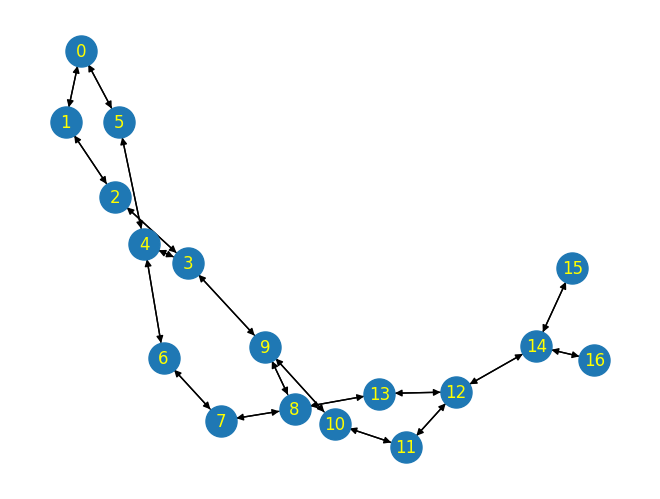

In [11]:
draw_jraph_graph_structure(g)

In [12]:
# Target for first graph
print(f"Target: {mutag_ds[0]['target']}")

Target: [1]


We see that there are 188 graphs, to be classified in one of 2 classes, representing "their mutagenic effect on a specific gram negative bacterium". Node features represent the 1-hot encoding of the atom type (0=C, 1=N, 2=O, 3=F, 4=I, 5=Cl, 6=Br). Edge features (`edge_attr`) represent the bond type, which we will here ignore.

Let's split the dataset to use the first 150 graphs as the training set (and the rest as the test set).

In [13]:
train_mutag_ds = mutag_ds[:150]
test_mutag_ds = mutag_ds[150:]

#### Padding Graphs to Speed Up Training

Since jax recompiles the program for each graph size, training would take a long time due to recompilation for different graph sizes. To address that, we pad the number of nodes and edges in the graphs to nearest power of two. Since jax maintains a cache
of compiled programs, the compilation cost is amortized.

In [14]:
# Adapted from https://github.com/deepmind/jraph/blob/master/jraph/ogb_examples/train.py
def _nearest_bigger_power_of_two(x: int) -> int:
  """Computes the nearest power of two greater than x for padding."""
  y = 2
  while y < x:
    y *= 2
  return y

def pad_graph_to_nearest_power_of_two(
    graphs_tuple: jraph.GraphsTuple) -> jraph.GraphsTuple:
  """Pads a batched `GraphsTuple` to the nearest power of two.
  For example, if a `GraphsTuple` has 7 nodes, 5 edges and 3 graphs, this method
  would pad the `GraphsTuple` nodes and edges:
    7 nodes --> 8 nodes (2^3)
    5 edges --> 8 edges (2^3)
  And since padding is accomplished using `jraph.pad_with_graphs`, an extra
  graph and node is added:
    8 nodes --> 9 nodes
    3 graphs --> 4 graphs
  Args:
    graphs_tuple: a batched `GraphsTuple` (can be batch size 1).
  Returns:
    A graphs_tuple batched to the nearest power of two.
  """
  # Add 1 since we need at least one padding node for pad_with_graphs.
  pad_nodes_to = _nearest_bigger_power_of_two(jnp.sum(graphs_tuple.n_node)) + 1
  pad_edges_to = _nearest_bigger_power_of_two(jnp.sum(graphs_tuple.n_edge))
  # Add 1 since we need at least one padding graph for pad_with_graphs.
  # We do not pad to nearest power of two because the batch size is fixed.
  pad_graphs_to = graphs_tuple.n_node.shape[0] + 1
  return jraph.pad_with_graphs(graphs_tuple, pad_nodes_to, pad_edges_to,
                               pad_graphs_to)

#### Loss and Accuracy Function
Define the classification cross-entropy loss and accuracy function.

In [15]:
def compute_loss(params: hk.Params, graph: jraph.GraphsTuple, label: jnp.ndarray,
                 net: jraph.GraphsTuple) -> Tuple[jnp.ndarray, jnp.ndarray]:
  """Computes loss and accuracy."""
  pred_graph = net.apply(params, graph)
  preds = jax.nn.log_softmax(pred_graph.globals)
  targets = jax.nn.one_hot(label, 2)

  # Since we have an extra 'dummy' graph in our batch due to padding, we want
  # to mask out any loss associated with the dummy graph.
  # Since we padded with `pad_with_graphs` we can recover the mask by using
  # get_graph_padding_mask.
  mask = jraph.get_graph_padding_mask(pred_graph)

  # Cross entropy loss.
  loss = -jnp.mean(preds * targets * mask[:, None])

  # Accuracy taking into account the mask.
  accuracy = jnp.sum(
      (jnp.argmax(pred_graph.globals, axis=1) == label) * mask) / jnp.sum(mask)
  return loss, accuracy

#### Training and Evaluation Functions

In [16]:
# Adapted from https://github.com/deepmind/jraph/blob/master/jraph/ogb_examples/train.py
def train(dataset: List[Dict[str, Any]], num_train_steps: int) -> hk.Params:
  """Training loop."""

  # Transform impure `net_fn` to pure functions with hk.transform.
  net = hk.without_apply_rng(hk.transform(net_fn_graph_classification))
  # Get a candidate graph and label to initialize the network.
  graph = dataset[0]['input_graph']

  # Initialize the network.
  params = net.init(jax.random.PRNGKey(42), graph)
  # Initialize the optimizer.
  opt_init, opt_update = optax.adam(1e-4)
  opt_state = opt_init(params)

  compute_loss_fn = functools.partial(compute_loss, net=net)
  # We jit the computation of our loss, since this is the main computation.
  # Using jax.jit means that we will use a single accelerator. If you want
  # to use more than 1 accelerator, use jax.pmap. More information can be
  # found in the jax documentation.
  compute_loss_fn = jax.jit(jax.value_and_grad(
      compute_loss_fn, has_aux=True))

  for idx in range(num_train_steps):
    graph = dataset[idx % len(dataset)]['input_graph']
    label = dataset[idx % len(dataset)]['target']
    # Jax will re-jit your graphnet every time a new graph shape is encountered.
    # In the limit, this means a new compilation every training step, which
    # will result in *extremely* slow training. To prevent this, pad each
    # batch of graphs to the nearest power of two. Since jax maintains a cache
    # of compiled programs, the compilation cost is amortized.
    graph = pad_graph_to_nearest_power_of_two(graph)

    # Since padding is implemented with pad_with_graphs, an extra graph has
    # been added to the batch, which means there should be an extra label.
    label = jnp.concatenate([label, jnp.array([0])])

    (loss, acc), grad = compute_loss_fn(params, graph, label)
    updates, opt_state = opt_update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    if idx % 50 == 0:
      print(f'step: {idx}, loss: {loss}, acc: {acc}')
  print('Training finished')
  return params

In [17]:
def evaluate(dataset: List[Dict[str, Any]],
             params: hk.Params) -> Tuple[jnp.ndarray, jnp.ndarray]:
  """Evaluation Script."""
  # Transform impure `net_fn` to pure functions with hk.transform.
  net = hk.without_apply_rng(hk.transform(net_fn_graph_classification))
  # Get a candidate graph and label to initialize the network.
  graph = dataset[0]['input_graph']
  accumulated_loss = 0
  accumulated_accuracy = 0
  compute_loss_fn = jax.jit(functools.partial(compute_loss, net=net))
  for idx in range(len(dataset)):
    graph = dataset[idx]['input_graph']
    label = dataset[idx]['target']
    graph = pad_graph_to_nearest_power_of_two(graph)
    label = jnp.concatenate([label, jnp.array([0])])
    loss, acc = compute_loss_fn(params, graph, label)
    accumulated_accuracy += acc
    accumulated_loss += loss
    if idx % 100 == 0:
      print(f'Evaluated {idx + 1} graphs')
  print('Completed evaluation.')
  loss = accumulated_loss / idx
  accuracy = accumulated_accuracy / idx
  print(f'Eval loss: {loss}, accuracy {accuracy}')
  return loss, accuracy

In [18]:
params = train(train_mutag_ds, num_train_steps=250)

step: 0, loss: 0.2843889594078064, acc: 0.0
step: 50, loss: 0.0006321418331936002, acc: 1.0
step: 100, loss: 0.0013380241580307484, acc: 1.0
step: 150, loss: 0.04702799394726753, acc: 1.0
step: 200, loss: 0.041739653795957565, acc: 1.0
Training finished


In [19]:
evaluate(test_mutag_ds, params)

Evaluated 1 graphs
Completed evaluation.
Eval loss: 0.1478191763162613, accuracy 0.7027026414871216


(Array(0.14781918, dtype=float32), Array(0.70270264, dtype=float32))

We converge at ~70% test accuracy. We could of course further tune the parameters to improve this result.

## [Optional for fun III] Link prediction on CORA (Citation Network)



### Edge prediction task

The final problem type we will explore is **link prediction**, an instance of an **edge-level** task. Given a graph, our goal is to predict whether a certain edge $(u,v)$ should be present or not. This is often useful in the recommender system settings (e.g., propose new friends in a social network, propose a movie to a user).

As before, the first step is to obtain node latents $h_i$ using a GNN. In this context we will use the autoencoder language and call this GNN **encoder**. Then, we learn a binary classifier $f: (h_i, h_j) \to z_{i,j}$ (**decoder**), predicting if an edge $(i,j)$ should exist or not. While we could use a more elaborate decoder (e.g., an MLP), a common approach we will also use here is to focus on obtaining good node embeddings, and for the decoder simply use the similarity between node latents, i.e. $z_{i,j} = h_i^T h_j$. Note that when defining the decoder, we need to consider whether the graph have undirected or directed graph; in the first case the function $f$ must be invariant w.r.t. the order of the nodes in each edge, i.e., $f(h_i, h_j) = z_{i,j} = z_{j,i} = f(h_j, h_i)$, while in the second case $f$ can also be variant.

In this third exercise we infer the existence of such edges on CORA Citation Network.



For this problem we will use the [**Cora** dataset](https://linqs.github.io/linqs-website/datasets/#cora), a citation graph containing 2708 scientific publications. For each publication we have a 1433-dimensional feature vector, which is a bag-of-words representation (with a small, fixed dictionary) of the paper text. The edges in this graph represent citations, and are commonly treated as undirected. Each paper is in one of seven topics (classes) so you can also use this dataset for node classification.

Similar to MUTAG, we have converted this dataset to jraph for you.

Citation for the use of the Cora dataset:
- [Qing Lu and Lise Getoor. Link-Based Classification. International Conference on Machine Learning. 2003.](https://linqs.github.io/linqs-website/publications/#id:lu-icml03)
- [Sen, Prithviraj, et al. Collective classification in network data. AI magazine 29.3. 2008.](https://linqs.github.io/linqs-website/datasets/#cora)
- [Dataset download link](https://linqs.github.io/linqs-website/datasets/#cora)




In [20]:
# Download jraph version of Cora.
!wget -P /tmp/ https://storage.googleapis.com/dm-educational/assets/graph-nets/jraph_datasets/cora.pickle
with open('/tmp/cora.pickle', 'rb') as f:
  cora_ds = pickle.load(f)

--2023-07-21 12:14:26--  https://storage.googleapis.com/dm-educational/assets/graph-nets/jraph_datasets/cora.pickle
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.153.128, 142.250.145.128, 74.125.128.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.153.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15618018 (15M) [application/octet-stream]
Saving to: ‘/tmp/cora.pickle’

cora.pickle         100%[===================>]  14.89M  26.0MB/s    in 0.6s    

2023-07-21 12:14:27 (26.0 MB/s) - ‘/tmp/cora.pickle’ saved [15618018/15618018]



#### Splitting Edges and Adding "Negative" Edges
For the link prediction task, we split the edges into train, val and test sets and also add "negative" examples (edges that do not correspond to a citation). We will ignore the topic classes.

For the validation and test splits, we add the same number of existing edges ("positive examples") and non-existing edges ("negative examples").

In contrast to the validation and test splits, the training split only contains positive examples (set $T_+$). The $|T_+|$ negative examples to be used during training will be sampled ad hoc in each epoch and uniformly at random from all edges that are not in $T_+$. This allows the model to see a wider range of negative examples.

In [21]:
def train_val_test_split_edges(graph: jraph.GraphsTuple,
                               val_perc: float = 0.05,
                               test_perc: float = 0.1):
  """Split edges in input graph into train, val and test splits.

  For val and test sets, also include negative edges.
  Based on torch_geometric.utils.train_test_split_edges.
  """
  mask = graph.senders < graph.receivers
  senders = graph.senders[mask]
  receivers = graph.receivers[mask]
  num_val = int(val_perc * senders.shape[0])
  num_test = int(test_perc * senders.shape[0])
  permuted_indices = onp.random.permutation(range(senders.shape[0]))
  senders = senders[permuted_indices]
  receivers = receivers[permuted_indices]
  if graph.edges is not None:
    edges = graph.edges[permuted_indices]

  val_senders = senders[:num_val]
  val_receivers = receivers[:num_val]
  if graph.edges is not None:
    val_edges = edges[:num_val]

  test_senders = senders[num_val:num_val + num_test]
  test_receivers = receivers[num_val:num_val + num_test]
  if graph.edges is not None:
    test_edges = edges[num_val:num_val + num_test]

  train_senders = senders[num_val + num_test:]
  train_receivers = receivers[num_val + num_test:]
  train_edges = None
  if graph.edges is not None:
    train_edges = edges[num_val + num_test:]

  # make training edges undirected by adding reverse edges back in
  train_senders_undir = jnp.concatenate((train_senders, train_receivers))
  train_receivers_undir = jnp.concatenate((train_receivers, train_senders))
  train_senders = train_senders_undir
  train_receivers = train_receivers_undir

  # Negative edges.
  num_nodes = graph.n_node[0]
  # Create a negative adjacency mask, s.t. mask[i, j] = True iff edge i->j does
  # not exist in the original graph.
  neg_adj_mask = onp.ones((num_nodes, num_nodes), dtype=onp.uint8)
  # upper triangular part
  neg_adj_mask = onp.triu(neg_adj_mask, k=1)
  neg_adj_mask[graph.senders, graph.receivers] = 0
  neg_adj_mask = neg_adj_mask.astype(onp.bool)
  neg_senders, neg_receivers = neg_adj_mask.nonzero()

  perm = onp.random.permutation(range(len(neg_senders)))
  neg_senders = neg_senders[perm]
  neg_receivers = neg_receivers[perm]

  val_neg_senders = neg_senders[:num_val]
  val_neg_receivers = neg_receivers[:num_val]
  test_neg_senders = neg_senders[num_val:num_val + num_test]
  test_neg_receivers = neg_receivers[num_val:num_val + num_test]

  train_graph = jraph.GraphsTuple(
      nodes=graph.nodes,
      edges=train_edges,
      senders=train_senders,
      receivers=train_receivers,
      n_node=graph.n_node,
      n_edge=jnp.array([len(train_senders)]),
      globals=graph.globals)

  return train_graph, neg_adj_mask, val_senders, val_receivers, val_neg_senders, val_neg_receivers, test_senders, test_receivers, test_neg_senders, test_neg_receivers

#### Test the Edge Splitting Function

In [22]:
graph = cora_ds[0]['input_graph']
train_graph, neg_adj_mask, val_pos_senders, val_pos_receivers, val_neg_senders, val_neg_receivers, test_pos_senders, test_pos_receivers, test_neg_senders, test_neg_receivers = train_val_test_split_edges(graph)

<ipython-input-21-37bddf7861ba>:50: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  neg_adj_mask = neg_adj_mask.astype(onp.bool)


In [23]:
print(f'Train set: {train_graph.senders.shape[0]} positive edges, we will sample the same number of negative edges at runtime')
print(f'Val set: {val_pos_senders.shape[0]} positive edges, {val_neg_senders.shape[0]} negative edges')
print(f'Test set: {test_pos_senders.shape[0]} positive edges, {test_neg_senders.shape[0]} negative edges')
print(f'Negative adjacency mask shape: {neg_adj_mask.shape}')
print(f'Numbe of negative edges to sample from: {neg_adj_mask.sum()}')

Train set: 8976 positive edges, we will sample the same number of negative edges at runtime
Val set: 263 positive edges, 263 negative edges
Test set: 527 positive edges, 527 negative edges
Negative adjacency mask shape: (2708, 2708)
Numbe of negative edges to sample from: 3660000



*Note*: It will often happen during training that as a negative example, we sample an initially existing edge (that is now e.g. a positive example in the test set). We are however not allowed to check for this, as we should be unaware of the existence of test edges during training.

Assuming our dot product decoder, we are essentially attempting to bring the latents of endpoints of edges from $T_+$ closer together, and make the latents of all other pairs of nodes as distant as possible. As this is impossible to fully satisfy, the hope is that the model will "fail" to distance those pairs of nodes where the edges should actually exist (positive examples from the test set).

#### Graph Network Model Definition

We will use jraph.GraphNetwork to build our graph net model.

We first define update functions for node features. We are not using edge or global features for this task.

In [24]:
@jraph.concatenated_args
def node_update_fn(feats: jnp.ndarray) -> jnp.ndarray:
  """Node update function for graph net."""
  # Define an MLP(128,128)

  ################
  # YOUR CODE HERE
  # net = ...
  net = hk.Sequential(
      [hk.Linear(64), jax.nn.relu,
       hk.Linear(64)])
  ################
  return net(feats)


def net_fn_link_prediction(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  """Network definition."""
  graph = graph._replace(globals=jnp.zeros([graph.n_node.shape[0], 1]))
  net = jraph.GraphNetwork(
      update_node_fn=node_update_fn, update_edge_fn=None, update_global_fn=None)
  return net(graph)


def decode(pred_graph: jraph.GraphsTuple, senders: jnp.ndarray,
           receivers: jnp.ndarray) -> jnp.ndarray:
  """Given a set of candidate edges, take dot product of respective nodes.

  Args:
    pred_graph: input graph.
    senders: Senders of candidate edges.
    receivers: Receivers of candidate edges.

  Returns:
    For each edge, computes dot product of the features of the two nodes.

  """
  # Implement the decoder as the dot product between node latents.

  ################
  # YOUR CODE HERE
  # similarity = ...
  similarity = jnp.sum(pred_graph.nodes[senders] * pred_graph.nodes[receivers], axis=1)
  ################
  return jnp.squeeze(similarity)

To evaluate our model, we first apply the sigmoid function to obtained dot products to get a score $s_{i,j} \in [0,1]$ for each edge. Now, we can pick a threshold $\tau$ and say that we predict all pairs $(i,j)$ s.t. $s_{i,j} \geq \tau$ as edges (and all the rest as non-edges).

#### Loss and ROC-AUC-Metric Function
Define the binary classification cross-entropy loss.
To aggregate the results over all choices of $\tau$, we will use ROC-AUC (the area under the ROC curve) as our evaluation metric.

In [25]:
from sklearn.metrics import roc_auc_score

def compute_bce_with_logits_loss(x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
  """Computes binary cross-entropy with logits loss.

  Combines sigmoid and BCE, and uses log-sum-exp trick for numerical stability.
  See https://stackoverflow.com/a/66909858 if you want to learn more.

  Args:
    x: Predictions (logits).
    y: Labels.

  Returns:
    Binary cross-entropy loss with mean aggregation.

  """
  max_val = jnp.clip(x, 0, None)
  loss = x - x * y + max_val + jnp.log(
      jnp.exp(-max_val) + jnp.exp((-x - max_val)))
  return loss.mean()


def compute_loss(params: hk.Params, graph: jraph.GraphsTuple,
                 senders: jnp.ndarray, receivers: jnp.ndarray,
                 labels: jnp.ndarray,
                 net: hk.Transformed) -> Tuple[jnp.ndarray, jnp.ndarray]:
  """Computes loss."""
  pred_graph = net.apply(params, graph)
  preds = decode(pred_graph, senders, receivers)
  loss = compute_bce_with_logits_loss(preds, labels)
  return loss, preds


def compute_roc_auc_score(preds: jnp.ndarray,
                          labels: jnp.ndarray) -> jnp.ndarray:
  """Computes roc auc (area under the curve) score for classification."""
  s = jax.nn.sigmoid(preds)
  roc_auc = roc_auc_score(labels, s)
  return roc_auc

Helper function for sampling negative edges during training.

In [26]:
def negative_sampling(
    graph: jraph.GraphsTuple, num_neg_samples: int,
    key: jnp.array) -> Tuple[jnp.array, jnp.array]:
  """Samples negative edges, i.e. edges that don't exist in the input graph."""
  num_nodes = graph.n_node[0]
  total_possible_edges = num_nodes**2
  # convert 2D edge indices to 1D representation.
  pos_idx = graph.senders * num_nodes + graph.receivers

  # Percentage to oversample edges, so most likely will sample enough neg edges.
  alpha = jnp.abs(1 / (1 - 1.1 *
                       (graph.senders.shape[0] / total_possible_edges)))

  perm = jax.random.randint(
      key,
      shape=(int(alpha * num_neg_samples),),
      minval=0,
      maxval=total_possible_edges,
      dtype=jnp.uint32)

  # mask where sampled edges are positive edges.
  mask = jnp.isin(perm, pos_idx)
  # remove positive edges.
  perm = perm[~mask][:num_neg_samples]

  # convert 1d back to 2d edge indices.
  neg_senders = perm // num_nodes
  neg_receivers = perm % num_nodes

  return neg_senders, neg_receivers


<ipython-input-26-2ee50fe24e52>:3: DeprecationWarning: jax.numpy.DeviceArray is deprecated. Use jax.Array.
  key: jnp.DeviceArray) -> Tuple[jnp.DeviceArray, jnp.DeviceArray]:


Let's write the training loop:

In [27]:
def train(dataset: List[Dict[str, Any]], num_epochs: int) -> hk.Params:
  """Training loop."""
  key = jax.random.PRNGKey(42)
  # Transform impure `net_fn` to pure functions with hk.transform.
  net = hk.without_apply_rng(hk.transform(net_fn_link_prediction))
  # Get a candidate graph and label to initialize the network.
  graph = dataset[0]['input_graph']

  train_graph, _, val_pos_s, val_pos_r, val_neg_s, val_neg_r, test_pos_s, \
      test_pos_r, test_neg_s, test_neg_r = train_val_test_split_edges(
      graph)

  # Prepare the validation and test data.
  val_senders = jnp.concatenate((val_pos_s, val_neg_s))
  val_receivers = jnp.concatenate((val_pos_r, val_neg_r))
  val_labels = jnp.concatenate(
      (jnp.ones(len(val_pos_s)), jnp.zeros(len(val_neg_s))))
  test_senders = jnp.concatenate((test_pos_s, test_neg_s))
  test_receivers = jnp.concatenate((test_pos_r, test_neg_r))
  test_labels = jnp.concatenate(
      (jnp.ones(len(test_pos_s)), jnp.zeros(len(test_neg_s))))
  # Initialize the network.
  params = net.init(key, train_graph)
  # Initialize the optimizer.
  opt_init, opt_update = optax.adam(1e-4)
  opt_state = opt_init(params)

  compute_loss_fn = functools.partial(compute_loss, net=net)
  # We jit the computation of our loss, since this is the main computation.
  # Using jax.jit means that we will use a single accelerator. If you want
  # to use more than 1 accelerator, use jax.pmap. More information can be
  # found in the jax documentation.
  compute_loss_fn = jax.jit(jax.value_and_grad(compute_loss_fn, has_aux=True))

  for epoch in range(num_epochs):
    num_neg_samples = train_graph.senders.shape[0]
    train_neg_senders, train_neg_receivers = negative_sampling(
        train_graph, num_neg_samples=num_neg_samples, key=key)
    train_senders = jnp.concatenate((train_graph.senders, train_neg_senders))
    train_receivers = jnp.concatenate(
        (train_graph.receivers, train_neg_receivers))
    train_labels = jnp.concatenate(
        (jnp.ones(len(train_graph.senders)), jnp.zeros(len(train_neg_senders))))

    (train_loss,
     train_preds), grad = compute_loss_fn(params, train_graph, train_senders,
                                          train_receivers, train_labels)

    updates, opt_state = opt_update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    if epoch % 10 == 0 or epoch == (num_epochs - 1):
      train_roc_auc = compute_roc_auc_score(train_preds, train_labels)
      val_loss, val_preds = compute_loss(params, train_graph, val_senders,
                                         val_receivers, val_labels, net)
      val_roc_auc = compute_roc_auc_score(val_preds, val_labels)
      print(f'epoch: {epoch}, train_loss: {train_loss:.3f}, '
            f'train_roc_auc: {train_roc_auc:.3f}, val_loss: {val_loss:.3f}, '
            f'val_roc_auc: {val_roc_auc:.3f}')
  test_loss, test_preds = compute_loss(params, train_graph, test_senders,
                                       test_receivers, test_labels, net)
  test_roc_auc = compute_roc_auc_score(test_preds, test_labels)
  print('Training finished')
  print(
      f'epoch: {epoch}, test_loss: {test_loss:.3f}, test_roc_auc: {test_roc_auc:.3f}'
  )
  return params

Let's train the model! We expect the model to reach roughly test_roc_auc of 0.84.

(Note that ROC-AUC is a scalar between 0 and 1, with 1 being the ROC-AUC of a perfect classifier.)

In [28]:
params = train(cora_ds, num_epochs=200)

<ipython-input-21-37bddf7861ba>:50: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  neg_adj_mask = neg_adj_mask.astype(onp.bool)


epoch: 0, train_loss: 0.690, train_roc_auc: 0.596, val_loss: 0.691, val_roc_auc: 0.592
epoch: 10, train_loss: 0.686, train_roc_auc: 0.664, val_loss: 0.689, val_roc_auc: 0.632
epoch: 20, train_loss: 0.682, train_roc_auc: 0.711, val_loss: 0.686, val_roc_auc: 0.659
epoch: 30, train_loss: 0.677, train_roc_auc: 0.743, val_loss: 0.684, val_roc_auc: 0.678
epoch: 40, train_loss: 0.671, train_roc_auc: 0.768, val_loss: 0.680, val_roc_auc: 0.696
epoch: 50, train_loss: 0.664, train_roc_auc: 0.790, val_loss: 0.675, val_roc_auc: 0.713
epoch: 60, train_loss: 0.654, train_roc_auc: 0.812, val_loss: 0.669, val_roc_auc: 0.734
epoch: 70, train_loss: 0.643, train_roc_auc: 0.834, val_loss: 0.661, val_roc_auc: 0.756
epoch: 80, train_loss: 0.631, train_roc_auc: 0.853, val_loss: 0.650, val_roc_auc: 0.778
epoch: 90, train_loss: 0.616, train_roc_auc: 0.870, val_loss: 0.638, val_roc_auc: 0.799
epoch: 100, train_loss: 0.599, train_roc_auc: 0.882, val_loss: 0.624, val_roc_auc: 0.817
epoch: 110, train_loss: 0.580, t

## Benchmarking

The `jraph` library allows to easily define the Graph Convolutional Network (GCN) and Graph Attention Layer (GAT) and create composite networks comprising of different layers. Please take a look at the [implementation of different layers](https://github.com/deepmind/jraph/blob/master/jraph/_src/models.py) provided by `jraph`. Here, we will be implementing GCN and GAT layers.

### GCN Building Blocks

In [29]:
add_self_edges = False
symmetric_normalization = True

### GAT Building Blocks

In [30]:
@jraph.concatenated_args
def attention_query_fn(feats: jnp.ndarray) -> jnp.ndarray:
  """Generates attention queries from sender node features."""
  # Define an MLP(128,128)

  ################
  # YOUR CODE HERE
  # net = ...
  net = hk.Sequential(
      [hk.Linear(EMBEDDING_SIZE), jax.nn.leaky_relu])

  ################
  return net(feats)

@jraph.concatenated_args
def attention_logit_fn(feats: jnp.ndarray) -> jnp.ndarray:
  """Converts attention queries into logits for softmax attention."""
  # Define an MLP(128,128)

  ################
  # YOUR CODE HERE
  # net = ...
  net = hk.Sequential(
      [hk.Linear(EMBEDDING_SIZE), jax.nn.leaky_relu,
       hk.Linear(EMBEDDING_SIZE)])

  ################
  return net(feats)

### Model Zoo

In [31]:
architecture = 'GraphNet'
def net_fn_graph_classification(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  # Add a global parameter for graph classification.
  graph = graph._replace(globals=jnp.zeros([graph.n_node.shape[0], 1]))

  # Build all networks for graph classification
  # embedder = ...
  # net = ...
  # attention_layer = ...
  # gcn_layer = ...
  ################
  # YOUR CODE HERE
  embedder = jraph.GraphMapFeatures(
      hk.Linear(EMBEDDING_SIZE), hk.Linear(EMBEDDING_SIZE), hk.Linear(EMBEDDING_SIZE))
  net = jraph.GraphNetwork(
      update_node_fn=node_update_fn,
      update_edge_fn=edge_update_fn,
      update_global_fn=update_global_fn)
  attention_layer = jraph.GAT(
      attention_query_fn=attention_query_fn,
      attention_logit_fn=attention_logit_fn,
      node_update_fn=node_update_fn
    )
  gcn_layer = jraph.GraphConvolution(
      update_node_fn=node_update_fn,
      add_self_edges=add_self_edges,
      symmetric_normalization=symmetric_normalization
  )
  ################

  if architecture == 'GraphNet':
    return net(embedder(graph))

  elif architecture == 'gat':
    return net(attention_layer(embedder(graph)))

  elif architecture == 'gcn':
    return net(gcn_layer(embedder(graph)))

  elif architecture == 'composite':
    ################
    # Play around :)
    pass
    ################

  else:
    raise ValueError

Is it okay to have a composite model where the attention layer / graph convolution layer is applied after the `net` layer? If not, why?

In [32]:
architecture = 'GraphNet'
def net_fn_link_prediction(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  # Add a global parameter for graph classification.
  graph = graph._replace(globals=jnp.zeros([graph.n_node.shape[0], 1]))

  # Build all networks for link prediction
  # net = ...
  # attention_layer = ...
  # gcn_layer = ...

  ################
  # YOUR CODE HERE
  graph = graph._replace(globals=jnp.zeros([graph.n_node.shape[0], 1]))
  net = jraph.GraphNetwork(
      update_node_fn=node_update_fn, update_edge_fn=None, update_global_fn=None)
  attention_layer = jraph.GAT(
      attention_query_fn=attention_query_fn,
      attention_logit_fn=attention_logit_fn,
      node_update_fn=node_update_fn
    )
  gcn_layer = jraph.GraphConvolution(
      update_node_fn=node_update_fn,
      add_self_edges=add_self_edges,
      symmetric_normalization=symmetric_normalization
  )
  ################

  if architecture == 'GraphNet':
    return net(graph)

  elif architecture == 'gat':
    return attention_layer(graph)

  elif architecture == 'gcn':
    return gcn_layer(graph)

  elif architecture == 'composite':
    ################
    # Play around :)
    pass
    ################

  else:
    raise ValueError

## Analysis

Play around with composite models with more than 1 layers. How does the performance of link prediction change? What would you attribute to this difference in performance?

Hidden response: 
Adding more layers introduces non-linearity into the model, which can increase the model's expressive power and allow it to learn more complex patterns in the data.
However models with many layers can suffer from vanishing or exploding gradients, which can make training more challenging. Proper normalization, careful initialization, and advanced optimization techniques can help mitigate these issues. Thus this tradeoff should explored per task.

## Summary
In this tutorial, we learned about how to represent directed and undirected graphs in jraph, how to create the basic GNN blocks (GCN + GAT) and how to compose them into GNNs. We also learned about three types of graph predictions tasks (node classification, link prediction and graph classification) and trained a model on each of these tasks.

To practice your knowledge, you can:


*   Create your own graphs, e.g. following the toy graph template and adding nodes, edges, features or using the `jraph` [collection of models](https://github.com/deepmind/jraph/blob/master/jraph/_src/models.py).


*   Modify the GNN blocks, e.g. by changing the update_node_fn() / update_edge_fn() functions.

*  Train a model on a different dataset and/or task.


